# CycleGAN Image-to-Image Translation
![](https://junyanz.github.io/CycleGAN/images/failures.jpg)
### CycleGAN and Notebook Structure

A CycleGAN is made of two types of networks: **discriminators, and generators**. In this example, the discriminators are responsible for classifying images as real or fake (for both $X$ and $Y$ kinds of images). The generators are responsible for generating convincing, fake images for both kinds of images. 

This notebook will detail the steps you should take to define and train such a CycleGAN. 

>1. You'll load in the image data using PyTorch's DataLoader class to efficiently read in images from a specified directory. 
2. Then, you'll be tasked with defining the CycleGAN architecture according to provided specifications. You'll define the discriminator and the generator models.
3. You'll complete the training cycle by calculating the adversarial and cycle consistency losses for the generator and discriminator network and completing a number of training epochs. *It's suggested that you enable GPU usage for training.*
4. Finally, you'll evaluate your model by looking at the loss over time and looking at sample, generated images.

## Load and Visualize the Data

In [ ]:
import os
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
import cv2
import functools

### DataLoaders

The `get_data_loader` function returns training and test DataLoaders that can load data efficiently and in specified batches. The function has the following parameters:
* `image_type`: `summer` or `winter`,  the names of the directories where the X and Y images are stored
* `image_dir`: name of the main image directory, which holds all training and test images
* `image_size`: resized, square image dimension (all images will be resized to this dim)
* `batch_size`: number of images in one batch of data

The test data is strictly for feeding to our generators, later on, so we can visualize some generated samples on fixed, test data.

You can see that this function is also responsible for making sure our images are of the right, square size (128x128x3) and converted into Tensor image types.

**It's suggested that you use the default values of these parameters.**

Note: If you are trying this code on a different set of data, you may get better results with larger `image_size` and `batch_size` parameters. If you change the `batch_size`, make sure that you create complete batches in the training loop otherwise you may get an error when trying to save sample data. 

In [ ]:
data_dir='../input/gan-getting-started'
class GANdataGenerator(Dataset):
    def __init__(self,data_dir ,  data_files , image_size ):
        super(GANdataGenerator , self).__init__()
        self.data_dir = data_dir
        self.data = data_files
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor()
        ])
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        data_file = self.data[index]
        data_file = os.path.join(self.data_dir , data_file)
        img_bgr = cv2.imread(data_file)
        img_rgb = cv2.cvtColor(img_bgr , cv2.COLOR_BGR2RGB)
        img_tensor = self.transform(img_rgb)
        
        return img_tensor

In [ ]:
monet_jpg = os.listdir('../input/gan-getting-started/monet_jpg')
photo_jpg = os.listdir('../input/gan-getting-started/photo_jpg')

In [ ]:
#load the Dataloader for X and Y image sets
X_type='photo_jpg'
Y_type='monet_jpg'
X_set = GANdataGenerator(data_dir='../input/gan-getting-started/photo_jpg' , data_files=photo_jpg , image_size=128 )
Y_set = GANdataGenerator(data_dir='../input/gan-getting-started/monet_jpg' , data_files=monet_jpg , image_size=128 )

X_dataloader = DataLoader(X_set , batch_size=16 , shuffle=True , num_workers=0)
Y_dataloader = DataLoader(Y_set , batch_size=16 , shuffle=True , num_workers=0)

In [ ]:
x_data = next(iter(X_dataloader))
y_data = next(iter(Y_dataloader))

# Visualize the data

In [ ]:
import matplotlib.pyplot as plt
print("X Data Visualization")
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(x_data))

In [ ]:
print("Y data Visualization")
fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(y_data))

In [ ]:
import matplotlib.pyplot as plt
def viz_sample(samples_x , samples_y):
    #get random sample from the x and y
    #plot the sample
    plt.title("Real sample")
    plt.imshow(samples_x)
    plt.show()
    plt.title("Fake sample")
    plt.imshow(samples_y)
    plt.show()

### Pre-processing: scaling from -1 to 1

We need to do a bit of pre-processing; we know that the output of our `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [ ]:
img = x_data[0]

print("Min : ",img.min())
print("Max : ",img.max())

def rescale(x , feature_range=(-1,1)):
    min , max = feature_range
    x = x*(max - min) +min
    
    return x

In [ ]:
# scaled range
scaled_img = rescale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

---
## Define the Model

A CycleGAN is made of two discriminator and two generator networks.

## Discriminators

The discriminators, $D_X$ and $D_Y$, in this CycleGAN are convolutional neural networks that see an image and attempt to classify it as real or fake. In this case, real is indicated by an output close to 1 and fake as close to 0. The discriminators have the following architecture:

![](https://ohinfa.files.wordpress.com/2017/04/discriminator.png?w=676)

This network sees a 256x256x3 image, and passes it through 5 convolutional layers that downsample the image by a factor of 2. The first four convolutional layers have a BatchNorm and ReLu activation function applied to their output, and the last acts as a classification layer that outputs one value.

### Convolutional Helper Function

To define the discriminators, you're expected to use the provided `conv` function, which creates a convolutional layer + an optional batch norm layer.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

#define the conv block for discriminator
def conv_block(in_channels , out_channels , kernel_size=4 , strides=2 ,padding_type='reflect' , padding=1 , batch_norm=True):
    layers = []
    if(padding_type=='reflect'):
        pad = nn.ReflectionPad2d(padding)
        layers.append(pad)
        
    if(padding_type=='replicate'):
        pad = nn.ReplicationPad2d(padding)
        layers.append(pad)
        
        
    conv_layer = nn.Conv2d(in_channels=in_channels , out_channels=out_channels , 
                          kernel_size=kernel_size , stride=strides , padding=0 ,  bias=False)
    layers.append(conv_layer)
    if(batch_norm):
        bn = nn.InstanceNorm2d(out_channels)
        layers.append(bn)
        
    return nn.Sequential(*layers)

### Define the Discriminator Architecture

The task is to fill in the `__init__` function with the specified 5 layer conv net architecture. Both $D_X$ and $D_Y$ have the same architecture, so we only need to define one class, and later instantiate two discriminators. 
> It's recommended that you use a **kernel size of 4x4** and use that to determine the correct stride and padding size for each layer. [This Stanford resource](http://cs231n.github.io/convolutional-networks/#conv) may also help in determining stride and padding sizes.

* Define convolutional layers in `__init__`
* Then fill in the forward behavior of the network

The `forward` function defines how an input image moves through the discriminator, and the most important thing is to pass it through your convolutional layers in order, with a **ReLu** activation function applied to all but the last layer.

You should **not** apply a sigmoid activation function to the output, here, and that is because we are planning on using a squared error loss for training. And you can read more about this loss function, later in the notebook.

In [ ]:
class Discriminator(nn.Module):
    
    def __init__(self , conv_dim , padding_mode):
        super(Discriminator , self).__init__()
        """
        Define the discriminator model to classify the images as real or fake
        in_channels =3
        out_channels=1
        """
        self.input_channels = 3
        self.output_channels = 1
        self.padding_mode = padding_mode
        # 256 - 256 -3 --> 128 - 128 -64
        self.conv_block1 = conv_block(self.input_channels , conv_dim  , padding_type=padding_mode)
        # 128 - 128 - 64 --> 64 - 64 - 128
        self.conv_block2 = conv_block(conv_dim , conv_dim*2 , padding_type=padding_mode)
        # 64 - 64 - 128 --> 32 - 32 - 256
        self.conv_block3 = conv_block(conv_dim*2 , conv_dim*4 , padding_type=padding_mode )
        # 32 - 32 - 256 --> 16 - 16 - 512
        #self.conv_block4 = conv_block(conv_dim*4 , conv_dim*8 , padding_type=padding_mode)
        # 16 - 16 - 512 --> 8 - 8 - 1024
        self.conv_block5 = conv_block(conv_dim*4 , self.output_channels , kernel_size=1 ,
                                      strides=1 ,padding_type=None ,  padding=0 , batch_norm=False)
        
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        
    def forward(self , x):
        x = self.leaky_relu(self.conv_block1(x))
        x = self.leaky_relu(self.conv_block2(x))
        x = self.leaky_relu(self.conv_block3(x))
        #x = self.leaky_relu(self.conv_block4(x))
        
        out = self.conv_block5(x)
        
        return out
        

# Generators

The generators, `G_XtoY` and `G_YtoX` (sometimes called F), are made of an **encoder**, a conv net that is responsible for turning an image into a smaller feature representation, and a **decoder**, a *transpose_conv* net that is responsible for turning that representation into an transformed image. These generators, one from XtoY and one from YtoX, have the following architecture:

![](https://miro.medium.com/max/2692/1*_KxtJIVtZjVaxxl-Yl1vJg.png)

This network sees a 256x256x3 image, compresses it into a feature representation as it goes through three convolutional layers and reaches a series of residual blocks. It goes through a few (typically 6 or more) of these residual blocks, then it goes through three transpose convolutional layers (sometimes called *de-conv* layers) which upsample the output of the resnet blocks and create a new image!

Note that most of the convolutional and transpose-convolutional layers have BatchNorm and ReLu functions applied to their outputs with the exception of the final transpose convolutional layer, which has a `tanh` activation function applied to the output. Also, the residual blocks are made of convolutional and batch normalization layers, which we'll go over in more detail, next.

---
### Residual Block Class

To define the generators, you're expected to define a `ResidualBlock` class which will help you connect the encoder and decoder portions of the generators. You might be wondering, what exactly is a Resnet block? It may sound familiar from something like ResNet50 for image classification, pictured below.

![](https://cdn-images-1.medium.com/max/1024/1*S3TlG0XpQZSIpoDIUCQ0RQ.jpeg)

ResNet blocks rely on connecting the output of one layer with the input of an earlier layer. The motivation for this structure is as follows: very deep neural networks can be difficult to train. Deeper networks are more likely to have vanishing or exploding gradients and, therefore, have trouble reaching convergence; batch normalization helps with this a bit. However, during training, we often see that deep networks respond with a kind of training degradation. Essentially, the training accuracy stops improving and gets saturated at some point during training. In the worst cases, deep models would see their training accuracy actually worsen over time!

One solution to this problem is to use **Resnet blocks** that allow us to learn so-called *residual functions* as they are applied to layer inputs. You can read more about this proposed architecture in the paper, [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf) by Kaiming He et. al, and the below image is from that paper.

![](https://cdn-images-1.medium.com/max/1600/1*5zSgo2L71FJos8XendgCvQ.jpeg)

### Residual Functions

Usually, when we create a deep learning model, the model (several layers with activations applied) is responsible for learning a mapping, `M`, from an input `x` to an output `y`.
>`M(x) = y` (Equation 1)

Instead of learning a direct mapping from `x` to `y`, we can instead define a **residual function**
> `F(x) = M(x) - x`

This looks at the difference between a mapping applied to x and the original input, x. `F(x)` is, typically, two convolutional layers + normalization layer and a ReLu in between. These convolutional layers should have the same number of inputs as outputs. This mapping can then be written as the following; a function of the residual function and the input x. The addition step creates a kind of loop that connects the input x to the output, y:
>`M(x) = F(x) + x` (Equation 2) or

>`y = F(x) + x` (Equation 3)

#### Optimizing a Residual Function

The idea is that it is easier to optimize this residual function `F(x)` than it is to optimize the original mapping `M(x)`. Consider an example; what if we want `y = x`?

From our first, direct mapping equation, **Equation 1**, we could set `M(x) = x` but it is easier to solve the residual equation `F(x) = 0`, which, when plugged in to **Equation 3**, yields `y = x`.


### Defining the `ResidualBlock` Class

To define the `ResidualBlock` class, we'll define residual functions (a series of layers), apply them to an input x and add them to that same input. This is defined just like any other neural network, with an `__init__` function and the addition step in the `forward` function. 

In our case, you'll want to define the residual block as:
* Two convolutional layers with the same size input and output
* Batch normalization applied to the outputs of the convolutional layers
* A ReLu function on the output of the *first* convolutional layer

Then, in the `forward` function, add the input x to this residual block. Feel free to use the helper `conv` function from above to create this block.

In [ ]:
#define the discriminator network with encoder - resblock - decoder
class ResidualBlock(nn.Module):
    """
    apply two conv layers with Batchnormalization and relu activation on first block
    """
    def __init__(self , conv_dim , padding_mode):
        super(ResidualBlock , self).__init__()
        self.conv_dim = conv_dim
        self.conv_block1 = conv_block(self.conv_dim , self.conv_dim , kernel_size=3 ,
                                      strides=1 ,padding_type=padding_mode , padding=1 , batch_norm=True)
        
        self.conv_block2 = conv_block(self.conv_dim , self.conv_dim , kernel_size=3 ,
                                      strides=1 ,padding_type=padding_mode, padding=1 , batch_norm=True)
        
        self.dropout = nn.Dropout(p=0.3)
        self.relu = nn.LeakyReLU(negative_slope=0.3 , inplace=True)
        
    def forward(self , x):
        res_1 = self.dropout(self.relu(self.conv_block1(x)))
        res_2 = self.conv_block2(res_1)
        out  = self.relu(res_2 + x)
        
        return out

### Transpose Convolutional Helper Function

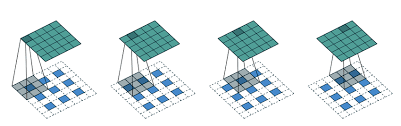

To define the generators, you're expected to use the above `conv` function, `ResidualBlock` class, and the below `deconv` helper function, which creates a transpose convolutional layer + an optional batchnorm layer.

In [ ]:
def deconv_block(in_channels , out_channels , kernel_size=4 , strides=2 , padding=1 , batch_norm=True):
    layers = []        
    deconv_layer = nn.ConvTranspose2d(in_channels=in_channels , out_channels=out_channels ,
                                      kernel_size=kernel_size , stride=strides , padding=padding , bias=False)
    layers.append(deconv_layer)
    if(batch_norm):
        bn = nn.InstanceNorm2d(out_channels)
        layers.append(bn)
        
    return nn.Sequential(*layers)

---
## Define the Generator Architecture

* Design the `__init__` function with the specified 3 layer **encoder** convolutional net, a series of residual blocks (the number of which is given by `n_res_blocks`), and then a 3 layer **decoder** transpose convolutional net.
* Then complete the `forward` function to define the forward behavior of the generators. Recall that the last layer has a `tanh` activation function.

Both $G_{XtoY}$ and $G_{YtoX}$ have the same architecture, so we only need to define one class, and later instantiate two generators.

## UNet Cycle Generator

In [ ]:
class CycleGenerator(nn.Module):
    """Create a Unet-based generator"""

    def __init__(self, input_nc, output_nc, num_downs, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet generator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            output_nc (int) -- the number of channels in output images
            num_downs (int) -- the number of downsamplings in UNet. For example, # if |num_downs| == 7,
                                image of size 128x128 will become of size 1x1 # at the bottleneck
            ngf (int)       -- the number of filters in the last conv layer
            norm_layer      -- normalization layer
        We construct the U-Net from the innermost layer to the outermost layer.
        It is a recursive process.
        """
        super(CycleGenerator, self).__init__()
        # construct unet structure
        unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True)  # add the innermost layer
        for i in range(num_downs - 5):          # add intermediate layers with ngf * 8 filters
            unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        # gradually reduce the number of filters from ngf * 8 to ngf
        unet_block = UnetSkipConnectionBlock(ngf * 4, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf * 2, ngf * 4, input_nc=None,no_skip=True ,  no_skip_outter=True , submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf, ngf * 2, input_nc=None, no_skip=True ,  submodule=unet_block, norm_layer=norm_layer)
        self.model = UnetSkipConnectionBlock(output_nc, ngf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer)  # add the outermost layer

    def forward(self, input):
        """Standard forward"""
        return self.model(input)


class UnetSkipConnectionBlock(nn.Module):
    """Defines the Unet submodule with skip connection.
        X -------------------identity----------------------
        |-- downsampling -- |submodule| -- upsampling --|
    """

    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, no_skip=False , no_skip_outter=False  , norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet submodule with skip connections.
        Parameters:
            outer_nc (int) -- the number of filters in the outer conv layer
            inner_nc (int) -- the number of filters in the inner conv layer
            input_nc (int) -- the number of channels in input images/features
            submodule (UnetSkipConnectionBlock) -- previously defined submodules
            outermost (bool)    -- if this module is the outermost module
            innermost (bool)    -- if this module is the innermost module
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
        """
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        self.no_skip = no_skip
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=use_bias)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)
        
        if no_skip :
            
            if(no_skip_outter):
                
                upconv = nn.ConvTranspose2d(inner_nc*2  , outer_nc,
                                            kernel_size=4, stride=2,
                                            padding=1, bias=use_bias)
                
            else:
                upconv = nn.ConvTranspose2d(inner_nc , outer_nc,
                                            kernel_size=4, stride=2,
                                            padding=1, bias=use_bias)
            
            down = [downrelu, downconv, downnorm]
            
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up
            

        elif outermost:
            upconv = nn.ConvTranspose2d(inner_nc , outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.no_skip:
          return self.model(x)  
    
        elif self.outermost:
            return self.model(x)
        else:   # add skip connections
            return torch.cat([x, self.model(x)], 1)

## Residual Cycle Generator

In [ ]:
class CycleGenerator(nn.Module):
    def __init__(self , conv_dim , n_resblocks , padding_mode):
        super(CycleGenerator , self).__init__()
        self.conv_dim = conv_dim
        self.n_resblocks = n_resblocks
        self.in_channels = 3
        self.out_channels = 3
        self.encoder = nn.Sequential(
            conv_block(self.in_channels , conv_dim , padding_type=padding_mode) ,
            nn.ReLU(True),
            conv_block(conv_dim , conv_dim*2 , padding_type=padding_mode), 
            nn.ReLU(True),
            conv_block(conv_dim*2 , conv_dim*4 , padding_type=padding_mode),
            nn.ReLU(True)
        )
        layers = []
        for i_res in range(self.n_resblocks):
            layers.append(ResidualBlock(conv_dim*4 , padding_mode=padding_mode))
        self.res_block = nn.Sequential(*layers)
        
        self.decoder =nn.Sequential(
            deconv_block(conv_dim*4 , conv_dim*2 ),
            nn.ReLU(True),
            deconv_block(conv_dim*2, conv_dim ),
            nn.ReLU(True),
            deconv_block(conv_dim , self.out_channels , batch_norm=False),
            nn.Tanh()
        )
    def forward(self, x):
        #inference throght the encoder
        x = self.encoder(x)
        x = self.res_block(x)
        x = self.decoder(x)
        
        return x

---
## Create the complete network

Using the classes you defined earlier, you can define the discriminators and generators necessary to create a complete CycleGAN. The given parameters should work for training.

First, create two discriminators, one for checking if $X$ sample images are real, and one for checking if $Y$ sample images are real. Then the generators. Instantiate two of them, one for transforming a painting into a realistic photo and one for transforming a photo into  into a painting.

In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if(classname.find('Conv') != -1):
        torch.nn.init.normal(m.weight.data , 0.0 , 0.02)
    elif(classname.find('Batchnorm2d')!= -1):
        torch.nn.init.normal(m.weight.data , 0.0 , 0.02)
        torch.nn.init.constant(m.bias.data , 0.0)

In [ ]:
def create_model(g_conv_dim=64 , d_conv_dim=64 , n_resblocks = 6 , padding_mode='reflect'):
    G_X2Y = CycleGenerator( input_nc =3 , output_nc=3, num_downs=5, ngf=64,  
                           norm_layer=nn.InstanceNorm2d, use_dropout=True)
    
    G_Y2X = CycleGenerator( input_nc=3, output_nc=3, num_downs=5, ngf=64, 
                           norm_layer=nn.InstanceNorm2d, use_dropout=True)
    
    #G_X2Y = CycleGenerator(conv_dim = g_conv_dim , n_resblocks=n_resblocks , padding_mode=padding_mode)
    #G_Y2X = CycleGenerator(conv_dim = g_conv_dim , n_resblocks=n_resblocks , padding_mode=padding_mode)
    
    D_X = Discriminator(d_conv_dim  ,padding_mode)
    D_Y = Discriminator(d_conv_dim , padding_mode)
    
    G_X2Y.apply(weights_init_normal)
    G_Y2X.apply(weights_init_normal)
    D_X.apply(weights_init_normal)
    D_Y.apply(weights_init_normal)
    
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    #move the models to gpu if availabele
    G_X2Y.to(device)
    G_Y2X.to(device)
    D_X.to(device)
    D_Y.to(device)
    
    return G_X2Y , G_Y2X , D_X , D_Y

In [ ]:
G_X2Y , G_Y2X , D_X , D_Y = create_model(padding_mode='replicate')

In [ ]:
G_X2Y.load_state_dict(torch.load('../input/cyclegan/generator_x2y.pth'))
G_Y2X.load_state_dict(torch.load('../input/cyclegan/generator_y2x.pth'))
D_X.load_state_dict(torch.load('../input/cyclegan/descriminator_x.pth'))
D_Y.load_state_dict(torch.load('../input/cyclegan/descriminator_y.pth'))

## Discriminator and Generator Losses

Computing the discriminator and the generator losses are key to getting a CycleGAN to train.

![](https://ruotianluo.github.io/assets/triplets/cycle4.png)

**Image from [original paper](https://arxiv.org/abs/1703.10593) by Jun-Yan Zhu et. al.**

* The CycleGAN contains two mapping functions $G: X \rightarrow Y$ and $F: Y \rightarrow X$, and associated adversarial discriminators $D_Y$ and $D_X$. **(a)** $D_Y$ encourages $G$ to translate $X$ into outputs indistinguishable from domain $Y$, and vice versa for $D_X$ and $F$.

* To further regularize the mappings, we introduce two cycle consistency losses that capture the intuition that if
we translate from one domain to the other and back again we should arrive at where we started. **(b)** Forward cycle-consistency loss and **(c)** backward cycle-consistency loss.

## Least Squares GANs

We've seen that regular GANs treat the discriminator as a classifier with the sigmoid cross entropy loss function. However, this loss function may lead to the vanishing gradients problem during the learning process. To overcome such a problem, we'll use a least squares loss function for the discriminator. This structure is also referred to as a least squares GAN or LSGAN, and you can [read the original paper on LSGANs, here](https://arxiv.org/pdf/1611.04076.pdf). The authors show that LSGANs are able to generate higher quality images than regular GANs and that this loss type is a bit more stable during training! 

### Discriminator Losses

The discriminator losses will be mean squared errors between the output of the discriminator, given an image, and the target value, 0 or 1, depending on whether it should classify that image as fake or real. For example, for a *real* image, `x`, we can train $D_X$ by looking at how close it is to recognizing and image `x` as real using the mean squared error:

```
out_x = D_X(x)
real_err = torch.mean((out_x-1)**2)
```

### Generator Losses

Calculating the generator losses will look somewhat similar to calculating the discriminator loss; there will still be steps in which you generate fake images that look like they belong to the set of $X$ images but are based on real images in set $Y$, and vice versa. You'll compute the "real loss" on those generated images by looking at the output of the discriminator as it's applied to these _fake_ images; this time, your generator aims to make the discriminator classify these fake images as *real* images. 

#### Cycle Consistency Loss

In addition to the adversarial losses, the generator loss terms will also include the **cycle consistency loss**. This loss is a measure of how good a reconstructed image is, when compared to an original image. 

Say you have a fake, generated image, `x_hat`, and a real image, `y`. You can get a reconstructed `y_hat` by applying `G_XtoY(x_hat) = y_hat` and then check to see if this reconstruction `y_hat` and the orginal image `y` match. For this, we recommed calculating the L1 loss, which is an absolute difference, between reconstructed and real images. You may also choose to multiply this loss by some weight value `lambda_weight` to convey its importance.


The total generator loss will be the sum of the generator losses and the forward and backward cycle consistency losses.

In [ ]:
criterion_Idt = nn.L1Loss()
criterion_gan = nn.MSELoss()
device='cuda' if torch.cuda.is_available() else 'cpu'
#define loss functions which are helpful
def real_mse_loss(D_out):
    # how close is the produced output from being "real"?
    target = torch.ones(D_out.shape,dtype=torch.float32).to(device)
    return criterion_gan(D_out, target)

def fake_mse_loss(D_out):
    # how close is the produced output from being "false"?
    target = torch.zeros(D_out.shape, dtype=torch.float32).to(device)
    return criterion_gan(D_out , target)
    

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    # calculate reconstruction loss 
    # return weighted loss
    reconstruct_loss = torch.mean(torch.abs(real_im-reconstructed_im))
    return reconstruct_loss*lambda_weight

def identity_loss(lambda_idt , idt_B ,real_B , idt_A , real_A , lambda_weight):
    
    if lambda_idt > 0:
        # G_A should be identity if real_B is fed: ||G_A(B) - B||
        loss_idt_A = criterion_Idt(idt_B, real_B) * lambda_weight * lambda_idt
        # G_B should be identity if real_A is fed: ||G_B(A) - A||
        loss_idt_B = criterion_Idt(idt_A, real_A) * lambda_weight * lambda_idt
    else:
        self.loss_idt_A = 0
        self.loss_idt_B = 0
        
    return loss_idt_A + loss_idt_B

## Define the optimizers

![](https://static.wixstatic.com/media/884a24_abb5ff293e4f4067bbf4b8618e5190ae~mv2.png)

In [ ]:
#define the optimizers
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# hyperparams for Adam optimizers
lr=0.0001
beta1=0.5
beta2= 0.999

g_params = list(G_X2Y.parameters()) + list(G_Y2X.parameters())  # Get generator parameters

# Create optimizers for the generators and discriminators
g_optimizer   = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

lambda1 = 3500
lambda2 = 8500


"""
Reduce learning rate when a metric has stopped improving. Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This scheduler 
reads a metrics quantity and if no improvement is seen for a ‘patience’ number of epochs, the learning rate is reduced.
"""

g_lr_scheduler = ReduceLROnPlateau(g_optimizer, mode='min', factor=0.1, patience=1500, 
                                threshold=0.01, threshold_mode='rel', cooldown=0,
                                   min_lr=0.000001, eps=1e-08, verbose=False)

#define lr scheduler
#g_lr_scheduler = MultiStepLR(g_optimizer, milestones=[lambda1,lambda2], gamma=0.1)
#dx_lr_scheduler =MultiStepLR(d_x_optimizer, milestones=[lambda1,lambda2], gamma=0.1)
#dy_lr_scheduler = MultiStepLR(d_y_optimizer, milestones=[lambda1,lambda2], gamma=0.1)

---

## Training a CycleGAN

When a CycleGAN trains, and sees one batch of real images from set $X$ and $Y$, it trains by performing the following steps:

**Training the Discriminators**
1. Compute the discriminator $D_X$ loss on real images
2. Generate fake images that look like domain $X$ based on real images in domain $Y$
3. Compute the fake loss for $D_X$
4. Compute the total loss and perform backpropagation and $D_X$ optimization
5. Repeat steps 1-4 only with $D_Y$ and your domains switched!


**Training the Generators**
1. Generate fake images that look like domain $X$ based on real images in domain $Y$
2. Compute the generator loss based on how $D_X$ responds to fake $X$
3. Generate *reconstructed* $\hat{Y}$ images based on the fake $X$ images generated in step 1
4. Compute the cycle consistency loss by comparing the reconstructions with real $Y$ images
5. Repeat steps 1-4 only swapping domains
6. Add up all the generator and reconstruction losses and perform backpropagation + optimization

![](https://www.researchgate.net/profile/Hritwick_Banerjee/publication/329368817/figure/fig7/AS:717806182076420@1548149738922/A-Training-Architecture-of-CycleGAN-B-Training-Architecture-of-a-CyCADA.png)

In [ ]:
# train the network
def training_loop(dataloader_X, dataloader_Y, test_dataloader_X , test_dataloader_Y, 
                  n_epochs=10000):
    
    print_every=50
    checkpoint_every=1000
    # keep track of losses over time
    losses = []

    test_iter_X = iter(dataloader_X)
    test_iter_Y = iter(dataloader_Y)

    # Get some fixed data from domains X and Y for sampling. These are images that are held
    # constant throughout training, that allow us to inspect the model's performance.
    fixed_X = test_iter_X.next()[0]
    fixed_Y = test_iter_Y.next()[0]
    fixed_X = rescale(fixed_X) # make sure to scale to a range -1 to 1
    fixed_Y = rescale(fixed_Y)

    # batches per epoch
    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    batches_per_epoch = min(len(iter_X), len(iter_Y))

    for epoch in range(1, n_epochs+1):
        
        
        # Reset iterators for each epoch
        if epoch % batches_per_epoch == 0:
            iter_X = iter(dataloader_X)
            iter_Y = iter(dataloader_Y)

        images_X = iter_X.next()
        images_X = rescale(images_X) # make sure to scale to a range -1 to 1

        images_Y = iter_Y.next()
        images_Y = rescale(images_Y)
        
        # move images to GPU if available (otherwise stay on CPU)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images_X = images_X.to(device)
        images_Y = images_Y.to(device)


        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================

        ##   First: D_X, real and fake loss components   ##

        # 1. Compute the discriminator losses on real images in X domain
        Dx_real_out = D_X(images_X)
        Dx_real_loss = real_mse_loss(Dx_real_out)
        
        # 2. Generate fake images that look like domain X based on real images in domain Y
        Gx_fake = G_Y2X(images_Y)
        
        # 3. Compute the fake loss for D_X on fake X
        Dx_fake_out= D_X(Gx_fake)
        Dx_fake_loss = fake_mse_loss(Dx_fake_out)
        
        # 4. Compute the total loss and perform backprop
        d_x_loss = Dx_real_loss + Dx_fake_loss
        #reste the optimizer
        d_x_optimizer.zero_grad()
        #backprop the loss
        d_x_loss.backward()
        #optimze the descrimintaer x
        d_x_optimizer.step()

        
        ##   Second: D_Y, real and fake loss components   ##
        Dy_real_out = D_Y(images_Y)
        Dy_real_loss = real_mse_loss(Dy_real_out)
        
        #generate fake images looks like the domain y on the real images in domain x
        Gy_fake = G_X2Y(images_X)
        
        #compute the descreminter fake loss
        Dy_fake_out = D_Y(Gy_fake)
        Dy_fake_loss = fake_mse_loss(Dy_fake_out)
        
        d_y_loss = Dy_fake_loss + Dy_real_loss
        #reset the optimizer
        d_y_optimizer.zero_grad()
        #backprop the loss
        d_y_loss.backward()
        #optimize the model
        d_y_optimizer.step()
        


        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================

        ##    First: generate fake X images and reconstructed Y images    ##

        # 1. Generate fake images that look like domain X based on real images in domain Y
        Gx_fake = G_Y2X(images_Y)

        # 2. Compute the generator loss based on domain X
        Dx_fake_out = D_X(Gx_fake)
        Gx_fake_loss = real_mse_loss(Dx_fake_out)

        # 3. Create a reconstructed y
        Gy_fake_re =  G_X2Y(Gx_fake) 
        
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        Gy_reconstruct_loss = cycle_consistency_loss(images_Y , Gy_fake_re , lambda_weight=10)

        ##    Second: generate fake Y images and reconstructed X images    ##
        Gy_fake = G_X2Y(images_X)
        
        #compute the generator fake loss on descriminator
        Dy_fake_out = D_Y(Gy_fake)
        Gy_fake_loss = real_mse_loss(Dy_fake_out)
        
        #regenerate the x images from fake y domain images
        Gx_fake_re = G_Y2X(Gy_fake)
        
        #compute the cycle consistnace loss on the real x and reconstructed x images
        Gx_reconstuct_loss = cycle_consistency_loss(images_X , Gx_fake_re , lambda_weight=10)
        
        #compute the identity loss
        idt_B = G_X2Y(images_Y)
        idt_A = G_Y2X(images_X)
        id_loss = identity_loss(0.1 , idt_B , images_Y ,
                                idt_A , images_X , lambda_weight=8)

        # 5. Add up all generator and reconstructed losses and perform backprop
        g_total_loss = Gx_fake_loss + Gy_fake_loss + Gy_reconstruct_loss + Gx_reconstuct_loss + id_loss
        
        #optimize the generator model
        g_optimizer.zero_grad()
        #back prop the loss
        g_total_loss.backward()
        #optimize the generator model
        g_optimizer.step()

        
        # Print the log info
        if epoch % print_every == 0:
            # append real and fake discriminator losses and the generator loss
            losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
                    epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))

            
        sample_every=1000
        # Save the generated samples
        if epoch % sample_every == 0:
            G_Y2X.eval() # set generators to eval mode for sample generation
            G_X2Y.eval()
            save_samples(epoch, fixed_Y, fixed_X, G_Y2X, G_X2Y, batch_size=16)
            G_Y2X.train()
            G_X2Y.train()
        
        g_lr_scheduler.step(g_total_loss)
        # uncomment these lines, if you want to save your model
#         checkpoint_every=1000
#         # Save the model parameters
        #if epoch % checkpoint_every == 0:
            #checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)

    return losses


## Helper functions

In [ ]:
# helper functions for saving sample data and models

# import data loading libraries
import os
import pdb
import pickle
import argparse

import warnings
warnings.filterwarnings("ignore")

# import torch
import torch


# numpy & scipy imports
import numpy as np
import scipy
import scipy.misc


def checkpoint(iteration, G_XtoY, G_YtoX, D_X, D_Y, checkpoint_dir='checkpoints_cyclegan'):
    """Saves the parameters of both generators G_YtoX, G_XtoY and discriminators D_X, D_Y.
        """
    G_XtoY_path = os.path.join(checkpoint_dir, 'G_XtoY.pkl')
    G_YtoX_path = os.path.join(checkpoint_dir, 'G_YtoX.pkl')
    D_X_path = os.path.join(checkpoint_dir, 'D_X.pkl')
    D_Y_path = os.path.join(checkpoint_dir, 'D_Y.pkl')
    torch.save(G_XtoY.state_dict(), G_XtoY_path)
    torch.save(G_YtoX.state_dict(), G_YtoX_path)
    torch.save(D_X.state_dict(), D_X_path)
    torch.save(D_Y.state_dict(), D_Y_path)


def merge_images(sources, targets, batch_size=16):
    """Creates a grid consisting of pairs of columns, where the first column in
        each pair contains images source images and the second column in each pair
        contains images generated by the CycleGAN from the corresponding images in
        the first column.
        """
    _, _, h, w = sources.shape
    row = int(np.sqrt(batch_size))
    merged = np.zeros([3, row*h, row*w*2])
    for idx, (s, t) in enumerate(zip(sources, targets)):
        i = idx // row
        j = idx % row
        merged[:, i*h:(i+1)*h, (j*2)*h:(j*2+1)*h] = s
        merged[:, i*h:(i+1)*h, (j*2+1)*h:(j*2+2)*h] = t
    merged = merged.transpose(1, 2, 0)
    return merged
    

def to_data(x):
    """Converts variable to numpy."""
    if torch.cuda.is_available():
        x = x.cpu()
    x = x.squeeze(0)
    x = x.data.numpy()
    x = np.transpose(x,(1,2,0))
    x = ((x +1)*255 / (2)).astype(np.uint8) # rescale to 0-255
    return x

def save_samples(iteration, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16, sample_dir='samples_cyclegan'):
    """Saves samples from both generators X->Y and Y->X.
        """
    # move input data to correct device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    fake_X = G_YtoX(fixed_Y.unsqueeze(0).to(device))
    fake_Y = G_XtoY(fixed_X.unsqueeze(0).to(device))
    
    X, fake_X = to_data(fixed_X), to_data(fake_X)
    Y, fake_Y = to_data(fixed_Y), to_data(fake_Y)
    
    #merged = merge_images(X, fake_Y, batch_size)
    #path = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    #scipy.misc.imsave(path, merged)
    #print('Saved {}'.format(path))
    viz_sample(X,fake_Y)
    viz_sample(Y,fake_X)
    #return fake_Y

## Tips on Training and Loss Patterns

A lot of experimentation goes into finding the best hyperparameters such that the generators and discriminators don't overpower each other. It's often a good starting point to look at existing papers to find what has worked in previous experiments, I'd recommend this [DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) in addition to the original [CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to see what worked for them. Then, you can try your own experiments based off of a good foundation.

#### Discriminator Losses

When you display the generator and discriminator losses you should see that there is always some discriminator loss; recall that we are trying to design a model that can generate good "fake" images. So, the ideal discriminator will not be able to tell the difference between real and fake images and, as such, will always have some loss. You should also see that $D_X$ and $D_Y$ are roughly at the same loss levels; if they are not, this indicates that your training is favoring one type of discriminator over the other and you may need to look at biases in your models or data.

#### Generator Loss

The generator's loss should start significantly higher than the discriminator losses because it is accounting for the loss of both generators *and* weighted reconstruction errors. You should see this loss decrease a lot at the start of training because initial, generated images are often far-off from being good fakes. After some time it may level off; this is normal since the generator and discriminator are both improving as they train. If you see that the loss is jumping around a lot, over time, you may want to try decreasing your learning rates or changing your cycle consistency loss to be a little more/less weighted.

In [ ]:
n_epochs = 10000 # keep this small when testing if a model first works, then increase it to >=1000

losses = training_loop(X_dataloader, Y_dataloader, X_dataloader, Y_dataloader, n_epochs=n_epochs)

# Conversion Visualization

In [ ]:
test_iter_X = iter(X_dataloader)
test_iter_Y = iter(Y_dataloader)

# Get some fixed data from domains X and Y for sampling. These are images that are held
# constant throughout training, that allow us to inspect the model's performance.
fixed_X = test_iter_X.next()
fixed_Y = test_iter_Y.next()
fixed_X = rescale(fixed_X) # make sure to scale to a range -1 to 1
fixed_Y = rescale(fixed_Y)
for fix_x , fix_y in zip(fixed_X , fixed_Y):
    save_samples(0, fix_y, fix_x, G_Y2X, G_X2Y, batch_size=1)

## Submission data generator

In [ ]:
X_set = GANdataGenerator(data_dir='../input/gan-getting-started/photo_jpg' , data_files=photo_jpg , image_size=128 )


X_dataloader = DataLoader(X_set , batch_size=1 , shuffle=True , num_workers=0)

## Generate Submission File

In [ ]:
!rm -rf images

In [ ]:
import PIL
! mkdir ../images

i = 1
for fix_x  in X_dataloader:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    fake_Y = G_X2Y(fix_x.to(device))
    
    prediction = to_data(fake_Y)
    im = PIL.Image.fromarray(prediction)
    
    im.save("../images/" + str(i) + ".jpg")
    i += 1
    
    
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

In [ ]:
torch.save(G_X2Y.state_dict(),"generator_x2y.pth")
torch.save(G_Y2X.state_dict(),"generator_y2x.pth")
torch.save(D_X.state_dict(),"descriminator_x.pth")
torch.save(D_Y.state_dict(),"descriminator_y.pth")